Each group is (1 x group_cols, N_events x event_cols)
Each flash is (1 x flash_cols, N_groups x group_cols)

So loop over each flash
    slice out all matching groups 
        loop over each group
            slice out all matching events
                yield a dataset reduced to just these parts that correspond to one flash



In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from glmtools.io.glm import GLMDataset

/Users/ebruning/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
filename = '/data/LCFA-production/OR_GLM-L2-LCFA_G16_s20152242125152_e20152242125357_c20152242125498.nc'

In [3]:
glm = GLMDataset(filename)
print glm.dataset

<xarray.Dataset>
Dimensions:                                 (number_of_events: 5018, number_of_field_of_view_bounds: 2, number_of_flashes: 2899, number_of_groups: 4899, number_of_time_bounds: 2, number_of_wavelength_bounds: 2)
Coordinates:
    event_id                                (number_of_events) int32 13521629 ...
    event_time_offset                       (number_of_events) datetime64[ns] 2015-08-12T21:25:14.732000 ...
    event_lat                               (number_of_events) float64 -47.5 ...
    event_lon                               (number_of_events) float64 -130.7 ...
    event_parent_group_id                   (number_of_events) int32 13280582 ...
    group_id                                (number_of_groups) int32 13280582 ...
    group_time_offset                       (number_of_groups) datetime64[ns] 2015-08-12T21:25:14.732000 ...
    group_lat                               (number_of_groups) float32 3.81698 ...
    group_lon                               (numb

In [4]:
def plot_flash(glm, some_flash):
    flash_data = glm.get_flash(some_flash)
    print(flash_data.number_of_events)

    ev_parent = flash_data.event_parent_group_id  
    gr_parent = flash_data.group_parent_flash_id


    gr_id = flash_data.group_id
    fl_id = flash_data.flash_id

    ev_lats = flash_data.event_lat.data
    ev_lons = flash_data.event_lon.data
    ev_time = flash_data.event_time_offset.data
    ev_rad = flash_data.event_energy.data
    gr_lat = flash_data.group_lat.data
    gr_lon = flash_data.group_lon.data
    gr_rad = flash_data.group_energy.data
    fl_lat = flash_data.flash_lat.data
    fl_lon = flash_data.flash_lon.data
    fl_rad = flash_data.flash_energy.data

#         print(flash_data)
#         print(gr_id.data)
#         print(fl_id.data)
#         print(ev_parent.data)
#         print(gr_parent.data)
#         print(ev_lats)
#         print(ev_lons)
#         print(ev_time)
#         print(gr_lat)
#         print(gr_lon)
#         print(gr_rad)
#         print(fl_lat)
#         print(fl_lon)
#         print(fl_rad)

    import matplotlib.pyplot as plt
    fig = plt.figure()
    ax_ev = fig.add_subplot(111)
    ax_ev.scatter(ev_lons, ev_lats, c=ev_rad, marker='s', cmap='gray', vmin=glm.energy_min, vmax=glm.energy_max)
    ax_ev.scatter(gr_lon, gr_lat, c=gr_rad, marker='o', vmin=glm.energy_min, vmax=glm.energy_max)
    ax_ev.scatter(fl_lon, fl_lat, c='r', marker='x') #, vmin=glm.energy_min, vmax=glm.energy_max)


    # prevent scientific notation
    ax_ev.get_xaxis().get_major_formatter().set_useOffset(False)
    ax_ev.get_yaxis().get_major_formatter().set_useOffset(False)

#         lon_min, lon_max = ev_lons.min()-.01, ev_lons.max()+.01, 
#         lat_min, lat_max = ev_lats.min()-.01, ev_lats.max()+.01
    lon_min, lon_max = gr_lon.min()-.01, gr_lon.max()+.01, 
    lat_min, lat_max = gr_lat.min()-.01, gr_lat.max()+.01
#         (lon_min, lon_max), (lat_min, lat_max) = glm.fov_bounds
#         ax_ev.axis((lon_min, lon_max, lat_min, lat_max))
#         return fig

<xarray.DataArray 'number_of_events' (number_of_events: 4)>
array([2789, 2790, 2791, 2792])
Coordinates:
    event_id               (number_of_events) int32 13524427 13524431 ...
    event_time_offset      (number_of_events) datetime64[ns] 2015-08-12T21:25:38.548000 ...
    event_lat              (number_of_events) float64 -46.63 -46.63 -46.63 ...
    event_lon              (number_of_events) float64 -136.1 -136.1 -136.1 ...
    event_parent_group_id  (number_of_events) int32 13283313 13283317 ...
    product_time           datetime64[ns] 2015-08-12T21:25:15.260505
    lightning_wavelength   float64 777.4
    group_time_threshold   float64 0.0
    flash_time_threshold   float64 3.33
    lat_field_of_view      float64 0.0
    lon_field_of_view      float64 -75.0
  * number_of_events       (number_of_events) int64 2789 2790 2791 2792


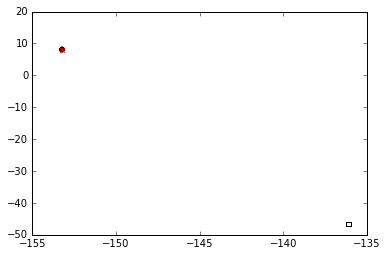

In [5]:
import ipywidgets as widgets
print(widgets.Widget.widget_types.values())
fl_id_vals = list(glm.dataset.flash_id.data)
fl_id_vals.sort()
flash_slider =  widgets.SelectionSlider(
    description='Flash',
    options=fl_id_vals,
)

from functools import partial
glm_plotter = partial(plot_flash, glm)
widgets.interact(glm_plotter, some_flash=flash_slider)


In [ ]:
# here is an example of a low-level read with xarray, and dumping data in a pretty way with pandas.
# experimental and not well tested.
some_flash = 16841 
# some_flash = 16468
# d = xr.open_dataset(filename)
singleton_flash_id = 15928


fov_dim = 'number_of_field_of_view_bounds'
wave_dim = 'number_of_wavelength_bounds'
time_dim = 'number_of_time_bounds'
gr_dim = 'number_of_groups'
ev_dim = 'number_of_events'
fl_dim = 'number_of_flashes'

# import pandas as pd
# d.indexes['number_of_events'] = pd.Int64Index(data=d.event_id.data, name='number_of_events')
# d.indexes['number_of_groups'] = pd.Int64Index(data=d.group_id.data, name='number_of_groups')
# d.indexes['number_of_flashes'] = pd.Int64Index(data=d.flash_id.data, name='number_of_flashes')

# empty = slice(0, 0)
# print(d[{fov_dim:empty, time_dim:empty, wave_dim:empty}])

# d = d[{'number_of_events':slice(0,0), 'number_of_groups':slice(0,0), 'number_of_flashes':slice(None)}]
# print(d)

In [5]:
# This is an example of a lower-level read, directly using NetCDF4
# instead of xarray. xarray does some additional metadata processing
# and provides groupby, etc., which is especially helpful when 
# querying clustered datasets with common keys linking data tables.

singleton_flash_id = 15928
singleton_group_id = 13280582
singleton_event_id = 13521629

# demonstrate it's not a problem with xarray
import netCDF4
nc = netCDF4.Dataset(filename)
this_ev = nc.variables['event_id'][:] == singleton_event_id
this_gr = nc.variables['group_id'][:] == singleton_group_id
this_fl = nc.variables['flash_id'][:] == singleton_flash_id

ev_id = nc.variables['event_id'][this_ev]
gr_id = nc.variables['group_id'][this_gr]
fl_id = nc.variables['flash_id'][this_fl]

ev_time_offset = nc.variables['event_time_offset']
print(ev_time_offset)
ev_times = netCDF4.num2date(ev_time_offset[:], units=ev_time_offset.units)
print ev_times[0:5]

ev_parent = nc.variables['event_parent_group_id'][this_ev]
gr_parent = nc.variables['group_parent_flash_id'][this_gr]

ev_lat = nc.variables['event_lat'][this_ev]
gr_lat = nc.variables['group_lat'][this_gr]
fl_lat = nc.variables['flash_lat'][this_fl]

# print(ev_id)
# print(ev_parent)
# print(gr_id)
# print(gr_parent)
# print(fl_id)
# print(ev_lat)
# print(gr_lat)
# print(fl_lat)

# print(nc)

# Dimensions:                                 (number_of_events: 1, number_of_field_of_view_bounds: 2, number_of_flashes: 1, number_of_groups: 1, number_of_time_bounds: 2, number_of_wavelength_bounds: 2)
# Coordinates:
#     event_id                                (number_of_events) int32 13521629
#     event_time_offset                       (number_of_events) datetime64[ns] 2015-08-12T21:25:14.732000 ...
#     event_lat                               (number_of_events) float64 -47.5
#     event_lon                               (number_of_events) float64 -130.7
#     event_parent_group_id                   (number_of_events) int32 13280582
#     group_id                                (number_of_groups) int32 13280582
#     group_time_offset                       (number_of_groups) datetime64[ns] 2015-08-12T21:25:14.732000 ...
#     group_lat                               (number_of_groups) float32 3.81698
#     group_lon                               (number_of_groups) float32 -126.438
#     group_parent_flash_id                   (number_of_groups) int16 15928
#     flash_id                                (number_of_flashes) int16 15928
#     flash_time_offset_of_first_event        (number_of_flashes) datetime64[ns] 2015-08-12T21:25:14.732000 ...
#     flash_time_offset_of_last_event         (number_of_flashes) datetime64[ns] 2015-08-12T21:25:14.732000 ...
#     flash_lat                               (number_of_flashes) float32 3.81698
#     flash_lon                               (number_of_flashes) float32 -126.438
#     product_time                            datetime64[ns] 2015-08-12T21:25:15.260505 ...
#     lightning_wavelength                    float64 777.4
#     group_time_threshold                    float64 0.0
#     flash_time_threshold                    float64 3.33
#     lat_field_of_view                       float64 0.0
#     lon_field_of_view                       float64 -75.0
#   * number_of_events                        (number_of_events) int64 0
#   * number_of_groups                        (number_of_groups) int64 0
#   * number_of_flashes                       (number_of_flashes) int64 0
#   * number_of_time_bounds                   (number_of_time_bounds) int64 0 1
#   * number_of_wavelength_bounds             (number_of_wavelength_bounds) int64 0 ...
#   * number_of_field_of_view_bounds          (number_of_field_of_view_bounds) int64 0 ...


<type 'netCDF4._netCDF4.Variable'>
int16 event_time_offset(number_of_events)
    long_name: GLM L2+ Lightning Detection: event’s time of occurrence
    standard_name: time
    scale_factor: 2.0
    add_offset: 0.0
    units: milliseconds since 2015-08-12 21:25:15.260
    axis: T
unlimited dimensions: number_of_events
current shape = (5018,)
filling on, default _FillValue of -32767 used

[datetime.datetime(2015, 8, 12, 21, 25, 14, 472000)
 datetime.datetime(2015, 8, 12, 21, 25, 14, 496000)
 datetime.datetime(2015, 8, 12, 21, 25, 14, 536000)
 datetime.datetime(2015, 8, 12, 21, 25, 14, 572000)
 datetime.datetime(2015, 8, 12, 21, 25, 14, 576000)]


In [31]:
# From earlier development - not needed.

def member_mask_for_cluster(dataset, cluster_id_column_name, cluster_ids):
    """ Given cluster_ids which correspond to values in 
        dataset.cluster_id_column_name, .
        """
    cluster_id_col = getattr(dataset, cluster_id_column_name)
    
    mask = np.zeros(cluster_id_col.shape[0], dtype=bool)
    for cluster_id in cluster_ids:
        mask |= (cluster_id == cluster_id_col)
    return mask

def gen_flashes(dataset):
    # need to set index on flash_id, group_id, and event_id coordinates.
    split_gr = d.groupby('group_parent_flash_id')
    # split_gr gives us a mapping from a flash index to the group indices
    # corresponding to that flash. Index refers to columns marked with 
    # an "*" in print(dataset)
    
    split_ev = d.groupby('event_parent_group_id')
    
    # careful: xarray uses groups to refer to the result of the groupby,
    # and does not refer here to GLM groups.
    for fl_idx, gr_idxs in split_gr.groups.items():
        # now we can use the flash index and group indices directly
        # need to pull out a combined set of event indices corresponding
        # to all groups
        ev_iter = (split_ev.groups[gr_id] for gr_id in gr_idxs)
        ev_idxs = list(itertools.chain.from_iterable(ev_iter))
        this_flash = d[{'number_of_events':ev_idxs, 'number_of_groups':gr_idxs, 'number_of_flashes':fl_idx}]

        yield this_flash

def get_flash(self, flash_id):
    good_gr = (self.group_parent_flash_id == flash_id)
    group_ids = self.group_id[good_gr]
    group_areas = self.group_area[good_gr]
    for group_area, group_id in zip(group_areas, group_ids):
        good_ev = (self.event_parent_group_id == group_id)
        pixel_energies = d.event_energy[good_ev]
        print(pixel_energies, type(group_area))
# get_flash(d, some_flash)

for fl in gen_flashes(d): print fl

# can we subset everything along the number_of_events dimension?

KeyError: 791

In [2]:
from functools import partial
partial?